In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import calculate_cleavage_rate as clv
reload(clv)
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as readM
reload(readM)
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()

### Load fit results

In [2]:
goodsim = [4,5,6,7,9,13,17,21,26,31,33,35,42,47,49,50,
          51,53,54,56,59,63,67,68,69,79,80,82,83,87,90,97] #40,75 are added because they give the highest correlations
#goodsim = range(1,26)
parameters = np.zeros([len(goodsim),42])
for i in range(len(goodsim)):
    filename = '../data/22_3_2019/fit_22_3_2019_sim_' + str(goodsim[i]) + '.txt'
    data = pd.read_table(filename,index_col=False)
    final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 43']
    final_par_np = final_par.values
    parameters[i][0:40] = final_par_np[1:41] #epsilon (no PAM)
    parameters[i][40] = final_par_np[42] #internal
    parameters[i][41] = 3.0 #cleavage
    
    
modelIDcleave = 'Clv_Saturated_general_energies_v2'
guide = 20
datafile = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerror = processing.prepare_multiprocessing_nucleaseq_log(datafile, path_to_data)
_,_,errormedian = processing.prepare_multiprocessing_nucleaseq(datafile, path_to_data, True)

### Chi-squared

In [3]:
chi = list()
for i in range(len(goodsim)):
    chitemp = 0.0
    for pos in range(len(xdata)):
        chitemp = chitemp + clv.calc_chi_squared(parameters[i],xdata[pos],ydata[pos],yerror[pos],[],guide,modelIDcleave)
    chi.append(chitemp)    
chi = np.array(chi)
    
print  'Lowest chi-squared: Fit ' + str(goodsim[np.argmin(chi)])
print chi[np.argmin(chi)]

Lowest chi-squared: Fit 51
178818.09246471


### On-target cleavage rate

In [4]:
ontarget = []
for i in range(len(goodsim)):
    ontarget.append(clv.calc_clv_rate_fast(parameters[i],modelIDcleave,[],guide))
ontarget = np.array(ontarget)
print 'Highest on-target rate: Fit ' + str(goodsim[np.argmax(ontarget)])

Highest on-target rate: Fit 9


### Correlation

In [5]:
correlation_coefficients_log = []
correlation_coefficients_log_full = []

for j in range(len(goodsim)):
    
    datapoints_log = []
    fitpoints_log = []
    datapoints_log_full = []
    fitpoints_log_full = []
    
    for i in range(len(xdata)):
        datapoints_log.append((np.average(ydata[i],weights=np.reciprocal(yerror[i]))))
        clvtemp = clv.calc_clv_rate_fast(parameters[j],modelIDcleave,xdata[i],guide)
        fitpoints_log.append(np.log10(clvtemp))
        for a in range(len(ydata[i])):
            if ydata[i][a]>(-10):
                datapoints_log_full.append((ydata[i][a]))
                fitpoints_log_full.append(np.log10(clvtemp))
        
    correlation_coefficients_log.append(np.corrcoef([datapoints_log,fitpoints_log])[0][1])
    correlation_coefficients_log_full.append(np.corrcoef([datapoints_log_full,fitpoints_log_full])[0][1])
    

correlation_coefficients_log = np.array(correlation_coefficients_log)
correlation_coefficients_log_full = np.array(correlation_coefficients_log_full)
print 'Highest loglog-correlation: Fit ' + str(goodsim[np.argmax(correlation_coefficients_log)]) + ' (' + str(correlation_coefficients_log[np.argmax(correlation_coefficients_log)]) + ')'
print 'Highest loglog-correlation on full data: Fit ' + str(goodsim[np.argmax(correlation_coefficients_log_full)]) + ' (' + str(correlation_coefficients_log_full[np.argmax(correlation_coefficients_log_full)]) + ')'

Highest loglog-correlation: Fit 59 (0.8031057300253199)
Highest loglog-correlation on full data: Fit 7 (0.886095817819251)


### Plots

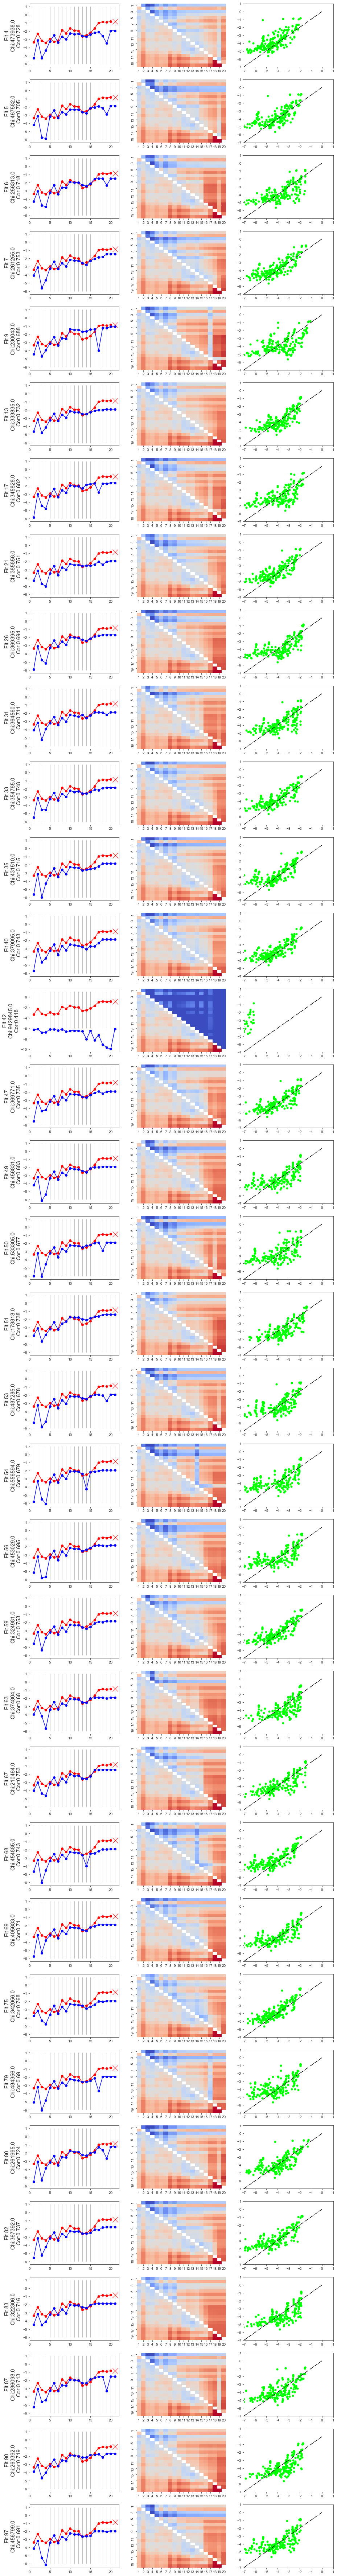

In [174]:
f,ax = plt.subplots(len(goodsim),3,sharey=False,figsize=[15,130])

kclvData = []
errormean = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclvData.append(np.average(ydata[a], weights=np.reciprocal(yerror[a])))
            errormean.append(errormedian[a])
            i = i + 1
            
errormean.append(errormedian[0])


k_data = np.zeros([20,20])
for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_data[j-1,i-1] = (np.average(ydata[a], weights=np.reciprocal(yerror[a])))

for j in range(len(goodsim)):
    
    kclv = list()
    for i in range(20):
        kclv.append(np.log10(clv.calc_clv_rate_fast(parameters[j],modelIDcleave,[i+1],20)))
    kclv.append(np.log10(clv.calc_clv_rate_fast(parameters[j],modelIDcleave,[],20)))
    
    ax[j][0].plot(range(1,21),kclvData,marker='o',color='r')
    ax[j][0].plot(21,np.average(ydata[0],weights=np.reciprocal(yerror[0])),marker='x',color='r',markersize=15)
    ax[j][0].plot(range(1,22),kclv,color='b',marker='o')
    ax[j][0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);
    ax[j][0].set_ylabel('Fit ' + str(goodsim[j]) + '\nChi:' + str(np.round(chi[j]))+ '\nCor:' + str(np.round(correlation_coefficients_log_full[j],3)),fontsize=15)
 

    k_double = np.zeros([20,20])
    for a in range(len(xdata)):
        if len(xdata[a])==2:
            x = xdata[a][0]
            y = xdata[a][1]
            k_double[x-1,y-1] = np.log10(clv.calc_clv_rate_fast(parameters[j],modelIDcleave,[x,y],guide))

    k_double_df = pd.DataFrame(k_double+k_data, index=range(1, 21), columns=range(1, 21))
    for i in range(1,21):
        k_double_df[i].loc[i]=np.nan

    sns.heatmap(k_double_df,cmap="coolwarm",cbar=False,ax=ax[j][1], vmin=-8, vmax=-1)

    datapoints = []
    fitpoints = []

    for i in range(len(xdata)):
        #datapoints.append(np.median(ydata[i]))
        datapoints.append(np.average(ydata[i],weights=np.reciprocal(yerror[i])))
        fitpoints.append(np.log10(clv.calc_clv_rate_fast(parameters[j],modelIDcleave,xdata[i],guide)))

    ax[j][2].plot(fitpoints,datapoints,marker='o',markersize=5,color='lime',linewidth=0.0)
    ax[j][2].plot([-7,0],[-7,0],'k-.')
    #ax[j][2].set_xlabel('Boyle fit cleavage prediction',fontsize=12)
    #ax[j][2].set_ylabel('Cleavage experiment data',fontsize=12)
    #ax[j][2].set_title('Correlation plot for fit ' + str(goodsim[j]),fontsize=12)
    ax[j][2].axis([-7,1,-7,1])

### Closer look at a specific fit

Text(0.5,1,'Fit 7, Double mismatches, top=model bottom=experiment')

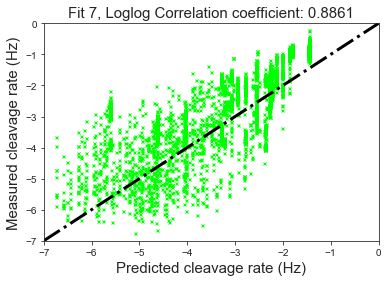

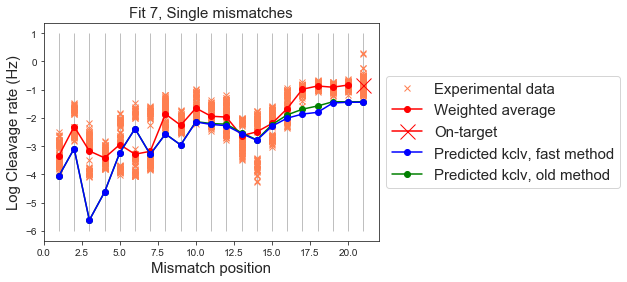

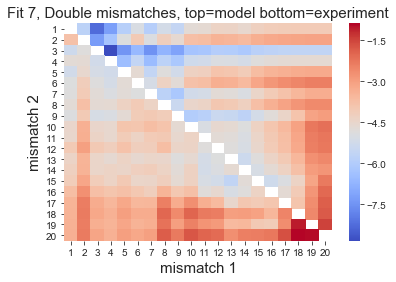

In [7]:
goodsimnp = np.array(goodsim)
number = np.where(goodsimnp==7)[0][0]
datapoints = []
fitpoints = []

for i in range(len(xdata)):
    cleavagetemp = np.log10(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,xdata[i],guide))
    
    ydatatemp = ydata[i]
    yerrtemp = yerror[i]
    ydatatemp = np.array(ydatatemp)
    yerrtemp =np.array(yerrtemp)
    indices =  np.where(ydatatemp>(-10))[0]
    ydata_select = ydatatemp[indices]
    yerr_select = yerrtemp[indices]
    
#    datapoints.append(np.average(ydata_select,weights=np.reciprocal(yerr_select)))
#    datapoints.append(np.median(ydata_select))
    
#    fitpoints.append(cleavagetemp)
    
    
    for j in range(len(ydata[i])): 
        if ydata[i][j]>(-10):
            datapoints.append(ydata[i][j])
            fitpoints.append(cleavagetemp)
        
plt.plot(fitpoints,datapoints,marker='x',markersize=3,color='lime',linewidth=0.0)
plt.plot([-7,0],[-7,0],'k-.',linewidth=3)
plt.axis([-7,0,-7,0])
plt.title('Fit ' + str(goodsim[number]) + ', Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datapoints,fitpoints])[0][1],4)), fontsize=15)
plt.xlabel('Predicted cleavage rate (Hz)',fontsize=15)
plt.ylabel('Measured cleavage rate (Hz)',fontsize=15)

kclvData = []
kclvWA = []
mmpos = []
kclv = []
kclvslow = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(np.log10(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[i],20)))
            kclvslow.append(np.log10(clv.calc_clv_rate(parameters[number],modelIDcleave,[i],20)))
            kclvData.append(ydata[a])
            kclvWA.append(np.average(ydata[a],weights=np.reciprocal(yerror[a])))
            #kclvWA.append(np.median(ydata[a]))
            mmpos.append(i*np.ones(len(ydata[a])))
            i = i + 1
            
kclv.append(np.log10(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[],20)))
kclvslow.append(np.log10(clv.calc_clv_rate(parameters[number],modelIDcleave,[],20)))
kclvData.append(ydata[0])
mmpos.append(21*np.ones(len(ydata[0])))
kclvWA.append(np.average(ydata[0],weights=np.reciprocal(yerror[0])))

            
plt.figure()       
for i in range(21):
    plot1 = plt.plot(mmpos[i],kclvData[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2 = plt.plot(range(1,21),kclvWA[0:20],marker='o',color='r',label='Weighted average')
plot3 = plt.plot(21,kclvWA[20],marker='x',color='r',markersize=15,label='On-target')
plot5 = plt.plot(range(1,22),kclvslow,color='g',marker='o',label='Predicted kclv, old method')
plot4 = plt.plot(range(1,22),kclv,color='b',marker='o',label='Predicted kclv, fast method')
plt.vlines(range(1,22),-6,1,color='grey',linewidth=0.5);
plt.legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0],plot5[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
plt.xlabel('Mismatch position',fontsize=15)
plt.ylabel('Log Cleavage rate (Hz)',fontsize=15)
plt.title('Fit ' + str(goodsim[number]) + ', Single mismatches',fontsize=15)

k_double = np.zeros([20,20])
for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (np.average(ydata[a], weights=np.reciprocal(yerror[a])))
        k_double[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(parameters[number],modelIDcleave,[i,j],guide))
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    k_double_df[i].loc[i]=np.nan
        
plt.figure()
sns.heatmap(k_double_df, cmap='coolwarm', cbar=True)#, vmin=-8, vmax = -1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('Fit ' + str(goodsim[number]) + ', Double mismatches, top=model bottom=experiment', fontsize=15)